# 2024年 世界モデル コンペティション 参考notebook  

第8回演習で利用したDreamerに修正を加え，Dreamer v2を用いたベースラインコードになっています．  
こちらを動かしていただけば，提出時にエラーが発生しない結果を得ることができます（参考用としてcolabの無料枠で1時間ほどで終わるようにパラメータを変えているため，性能は出ないです）．  

**目次**
1. [準備](#scrollTo=b986f379-97f5-4449-b4c6-7cc385d1f474)
2. [環境の設定](#scrollTo=c7819663-fffc-44e5-842f-779564dd8227)
3. [補助機能の実装](#scrollTo=6b9cdd13-ce4a-44b4-a01d-5a19d4e38bae)
4. [モデルの実装](#scrollTo=0662612e-701b-41a2-8679-25ad03fef367)
5. [学習](#scrollTo=b06c188f-8a87-42e7-9f61-7f385eccc565)
6. [モデルの保存](#scrollTo=aa693a51-a4cb-4ad4-be2b-322cbd68443d)
7. [学習済みパラメータで評価](#scrollTo=c4b31352-bafa-46ed-8bcc-632a24dfced6)

以下良い性能を出すためにできる工夫の例です．  
- ハイパーパラメータを調整する．  
  - バッチサイズを大きくする．
  - 更新回数を増やす（update_freqを小さくする）．
  - モデルの次元数を大きくする．  など
- Dreamer v2の各モデルのアーキテクチャを変更する．
- Dreamer v2以外の学習手法を用いる．

## 1. 準備  

必要なライブラリのインストール．各自必要なライブラリがある場合は追加でインストールしてください．  

In [ ]:
# !pip install gym==0.26.2 gym[atari]==0.26.2 gym[accept-rom-license]==0.26.2 autorom ale-py

### 1.1 ライブラリインポート  

In [21]:
import time
import os
import gc
import random
from copy import deepcopy
from typing import Any, List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm.notebook import tqdm
import wandb

# import gym
import gymnasium as gym
from gymnasium.wrappers import ResizeObservation
import gymnasium_robotics
import torch
import torch.distributions as td
from torch.distributions import Normal, Categorical, OneHotCategorical, OneHotCategoricalStraightThrough
from torch.distributions.kl import kl_divergence
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_

%env MUJOCO_GL=egl
gym.register_envs(gymnasium_robotics)

env: MUJOCO_GL=egl


## 2. 環境の設定  

### 2.1 Repeat Action  
- こちらで実装している環境を用いてOmnicampus上では評価を行います．  
- モデルによって変更する可能性があると想定している部分は以下のとおりです．
    - 画像のレンダリングサイズ(ResizeObervationクラスのshape)．
    - 同じ行動を繰り返す数（RepeatActionクラスのskip）

In [65]:
class CustomManipulateBoxEnv(gym.Env):
    def __init__(self, env, image_size=64):
        super().__init__()
        self.env = env
        self._render_width = image_size
        self._render_height = image_size
        self.box_drop_threshold = 0.05  # 卵が落下したと判断する高さの閾値（メートル単位）

    def reset(self, **kwargs):
        observation, info = self.env.reset(**kwargs)
        obs_hand_all = np.concatenate([observation['observation'], observation['desired_goal'], observation['achieved_goal']], axis=-1)
        img = self.render() # observation
        return img, obs_hand_all

    def step(self, action):
        observation, reward, done, truncated, info = self.env.step(action)
        obs_hand_all = np.concatenate([observation['observation'], observation['desired_goal'], observation['achieved_goal']], axis=-1)
        # if self.num_touch_fingers(observation["observation"]) <= 2:
        #     reward -= 5
        # if reward > -0.4:
        #     reward = 10
        if observation["observation"][56] < self.box_drop_threshold:
            reward = -100
            done = True
        image = self.render() # observation
        return image, obs_hand_all, reward, done, info

    def render(self):
        img = self.env.render()
        img = img[120:400, 200:480]
        img = cv2.resize(img, (self._render_height, self._render_width), interpolation=cv2.INTER_LINEAR)
        return img
    
    # def num_touch_fingers(self, observation_hand):
    #     return np.count_nonzero(observation_hand[61:])

    def close(self):
        self.env.close()

    def __getattr__(self, name):
        return getattr(self.env, name)
    
class RepeatAction(CustomManipulateBoxEnv):
    """
    同じ行動を指定された回数自動的に繰り返すラッパー. 観測は最後の行動に対応するものになる
    """
    def __init__(self, env, skip=4, max_steps=100):
        gym.Wrapper.__init__(self, env)
        self.max_steps = max_steps if max_steps else float("inf")  # イテレーションの制限
        self.steps = 0  # イテレーション回数のカウント
        self._skip = skip

    @property
    def observation_space():
        img = self.env.render()
        return gym.spaces.Box(img)
        
    def reset(self):
        img, obs = self.env.reset()
        self.steps = 0
        return img, obs

    def step(self, action):
        # if self.steps >= self.max_steps:  # 100kに達したら何も返さないようにする
        #     print("Reached max iterations.")
        #     return None

        total_reward = 0.0
        self.steps += 1
        for _ in range(self._skip):
            img, obs, reward, done, info = self.env.step(action)
            # img = self.env.render()
            total_reward += reward
            if self.steps >= self.max_steps:  # 100kに達したら終端にする
                done = True

            if done:
                break

        return img, obs, total_reward, done, info

In [66]:
def make_env(seed=None, img_size=64, max_steps=100):
    # env = gym.make("ALE/MsPacman-v5")
    env = gym.make('HandManipulateBlockRotateZDense-v1', render_mode="rgb_array", max_episode_steps=max_steps)

    # シード固定
    # env.seed(seed)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

    # env = ResizeObservation(env, (img_size, img_size))
    env = CustomManipulateBoxEnv(env, image_size=img_size)
    env = RepeatAction(env, skip=2, max_steps=max_steps)

    return env

-8.43791464884224


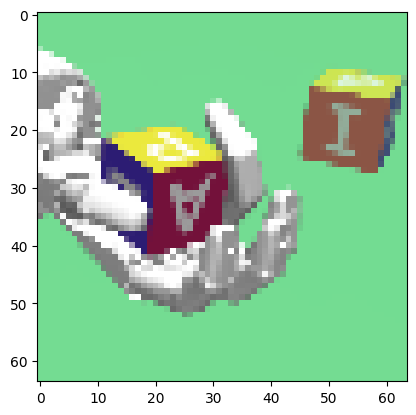

-8.62865897732862


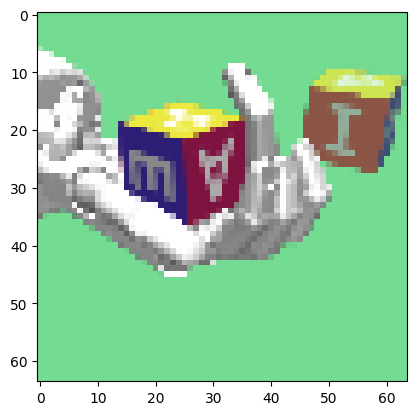

-8.582431104672068


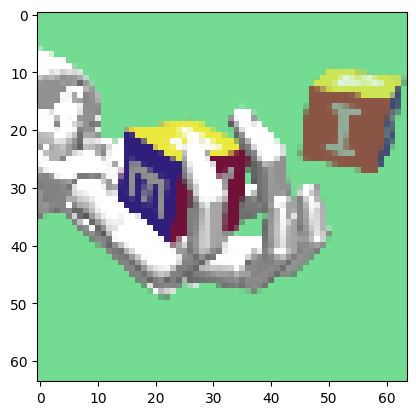

-8.370398458561585


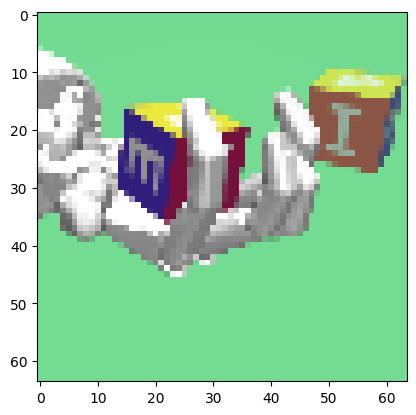

-8.397973117960909


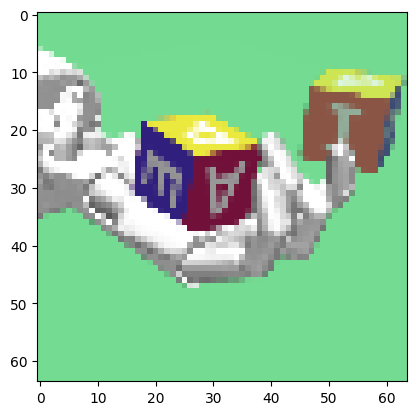

In [67]:
env = make_env(seed=1234)

for _ in range(5):
    action = env.action_space.sample()  # User-defined policy function
    img, obs, reward, terminated, info = env.step(action)
    # print(np.count_nonzero(obs[61:61+92]))
    print(reward)
    plt.imshow(img)
    plt.show()

## 3. 補助機能の実装  
- モデルを保存する際に利用できるクラス，torchのシード値を固定できる関数です．   
- 提出いただくパラメータの保存や読み込みにこちらのクラスを必ず利用する必要はありません  ．

In [25]:
# モデルパラメータをGoogleDriveに保存・後で読み込みするためのヘルパークラス
class TrainedModels:
    def __init__(self, *models) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        models : nn.Module
            保存するモデル．複数モデルを渡すことができます．

        使用例: trained_models = TraindModels(encoder, rssm, value_model, action_model)
        """
        assert np.all([nn.Module in model.__class__.__bases__ for model in models]), "Arguments for TrainedModels need to be nn models."

        self.models = models

    def save(self, dir: str) -> None:
        """
        initで渡したモデルのパラメータを保存します．
        パラメータのファイル名は01.pt, 02.pt, ... のように連番になっています．

        Parameters
        ----------
        dir : str
            パラメータの保存先．
        """
        for i, model in enumerate(self.models):
            torch.save(
                model.state_dict(),
                os.path.join(dir, f"{str(i + 1).zfill(2)}.pt")
            )

    def load(self, dir: str, device: str) -> None:
        """
        initで渡したモデルのパラメータを読み込みます．

        Parameters
        ----------
        dir : str
            パラメータの保存先．
        device : str
            モデルをどのデバイス(CPU or GPU)に載せるかの設定．
        """
        for i, model in enumerate(self.models):
            model.load_state_dict(
                torch.load(
                    os.path.join(dir, f"{str(i + 1).zfill(2)}.pt"),
                    map_location=device
                )
            )

In [26]:
def set_seed(seed: int) -> None:
    """
    Pytorch, NumPyのシード値を固定します．これによりモデル学習の再現性を担保できます．

    Parameters
    ----------
    seed : int
        シード値．
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 4. モデルの実装  
本notebookでは例としてDreamer v2を用いています．  
参考: https://arxiv.org/pdf/2010.02193.pdf  

**必要なモデル**  
- RSSM
    - Recurrent model: $h_t = f_{\phi} (h_{t-1}, z_{t-1}, a_{t-1})$
    - Representation model(=posterior): $z_t \sim q_{\phi} (z_t | h_t, x_t)$
    - Transition predictor(=prior): $\hat{z}_t \sim p_{\phi} (\hat{z}_t | h_t)$
- Image predictor(=Decoder): $\hat{x}_t \sim p_{\phi} (\hat{x}_t | h_t, z_t)$
- Reward predictor(=RewardModel): $\hat{r}_t \sim p_{\phi} (\hat{r}_t | h_t, z_t)$
- Discount predictor(=DiscountModel): $\hat{\gamma}_t \sim p_{\phi} (\hat{\gamma}_t | h_t, z_t)$
- (Encoder): x_tを入力するときには，一度ベクトルに変換する．
- Actor: $\hat{a}_t \sim p_{\psi}(\hat{a}_t | \hat{z}_t)$
- Critic: $v_{\xi}(\hat{z}_t) \approx E_{p_{\phi}, p_{\psi}} [\sum_{{\tau} \geq t} \hat{\gamma}^{\tau- t} \hat{r}_{\tau}]$

In [27]:
class RSSM(nn.Module):
    def __init__(self, mlp_hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int, action_dim: int, obs_hand_dim: int):
        super().__init__()

        self.rnn_hidden_dim = rnn_hidden_dim
        self.state_dim = state_dim
        self.num_classes = num_classes
        self.obs_hand_dim = obs_hand_dim

        # Recurrent model
        # h_t = f(h_t-1, z_t-1, a_t-1)
        self.transition_hidden = nn.Linear(state_dim * num_classes + action_dim, mlp_hidden_dim)
        self.transition = nn.GRUCell(mlp_hidden_dim, rnn_hidden_dim)

        # transition predictor
        self.prior_hidden = nn.Linear(rnn_hidden_dim, mlp_hidden_dim)
        self.prior_logits = nn.Linear(mlp_hidden_dim, state_dim * num_classes)

        # representation model
        self.posterior_hidden = nn.Linear(rnn_hidden_dim + 1536 + obs_hand_dim, mlp_hidden_dim) # 修正
        self.posterior_logits = nn.Linear(mlp_hidden_dim, state_dim * num_classes)

    def recurrent(self, state: torch.Tensor, action: torch.Tensor, rnn_hidden: torch.Tensor):
        # recullent model: h_t = f(h_t-1, z_t-1, a_t-1)を計算する
        hidden = F.elu(self.transition_hidden(torch.cat([state, action], dim=1)))
        rnn_hidden = self.transition(hidden, rnn_hidden)

        return rnn_hidden  # h_t

    def get_prior(self, rnn_hidden: torch.Tensor, detach=False):
        # transition predictor: \hat{z}_t ~ p(z\hat{z}_t | h_t)
        hidden = F.elu(self.prior_hidden(rnn_hidden))
        logits = self.prior_logits(hidden)
        logits = logits.reshape(logits.shape[0], self.state_dim, self.num_classes)

        prior_dist = td.Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detach_prior = td.Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return prior_dist, detach_prior  # p(z\hat{z}_t | h_t)
        return prior_dist

    def get_posterior(self, rnn_hidden: torch.Tensor, embedded_obs: torch.Tensor, detach=False):
        # representation predictor: z_t ~ q(z_t | h_t, o_t)
        hidden = F.elu(self.posterior_hidden(torch.cat([rnn_hidden, embedded_obs], dim=1)))
        logits = self.posterior_logits(hidden)
        logits = logits.reshape(logits.shape[0], self.state_dim, self.num_classes)

        posterior_dist = td.Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detach_posterior = td.Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return posterior_dist, detach_posterior  # q(z_t | h_t, o_t)
        return posterior_dist

In [28]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 48, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(48, 96, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(96, 192, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(192, 384, kernel_size=4, stride=2)

    def forward(self, obs: torch.Tensor, obs_hand: torch.Tensor):
        """
        観測画像をベクトルに埋め込むためのEncoder．

        Parameters
        ----------
        obs : torch.Tensor (B, C, H, W)
            入力となる観測画像．

        Returns
        -------
        embedded_obs : torch.Tensor (B, D)
            観測画像をベクトルに変換したもの．Dは入力画像の幅と高さに依存して変わる．
            入力が(B, 3, 64, 64)の場合，出力は(B, 1536)になる．
        """
        hidden = F.elu(self.conv1(obs))
        hidden = F.elu(self.conv2(hidden))
        hidden = F.elu(self.conv3(hidden))
        embedded_obs = self.conv4(hidden).reshape(hidden.size(0), -1)

        embedded_obs = torch.cat([embedded_obs, obs_hand], dim=-1) # 画像情報とobs_handを結合

        return embedded_obs  # x_t

In [29]:
class Decoder(nn.Module):
    def __init__(self, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()
        self.fc = nn.Linear(state_dim*num_classes + rnn_hidden_dim, 1536)
        self.dc1 = nn.ConvTranspose2d(1536, 192, kernel_size=5, stride=2)
        self.dc2 = nn.ConvTranspose2d(192, 96, kernel_size=5, stride=2)
        self.dc3 = nn.ConvTranspose2d(96, 48, kernel_size=6, stride=2)
        self.dc4 = nn.ConvTranspose2d(48, 1, kernel_size=6, stride=2)


    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor):
        """
        決定論的状態と，確率的状態を入力として，観測画像を復元するDecoder．
        出力は多次元正規分布の平均値をとる．

        Paremters
        ---------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        obs_dist : torch.distribution.Independent
            観測画像を再構成するための多次元正規分布．
        """
        hidden = self.fc(torch.cat([state, rnn_hidden], dim=1))
        hidden = hidden.view(hidden.size(0), 1536, 1, 1)
        hidden = F.elu(self.dc1(hidden))
        hidden = F.elu(self.dc2(hidden))
        hidden = F.elu(self.dc3(hidden))
        mean = self.dc4(hidden)

        obs_dist = td.Independent(td.Normal(mean, 1), 3)
        return obs_dist  # p(\hat{x}_t | h_t, z_t)

In [30]:
class RewardModel(nn.Module):
    def __init__(self, hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim*num_classes + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor):
        """
        決定論的状態と，確率的状態を入力として，報酬を予測するモデル．
        出力は正規分布の平均値をとる．

        Paremters
        ---------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        reward_dist : torch.distribution.Independent
            報酬を予測するための正規分布．
        """
        hidden = F.elu(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = F.elu(self.fc2(hidden))
        hidden = F.elu(self.fc3(hidden))
        mean = self.fc4(hidden)

        reward_dist = td.Independent(td.Normal(mean, 1),  1)
        return reward_dist  # p(\hat{r}_t | h_t, z_t)

In [31]:
class DiscountModel(nn.Module):
    def __init__(self, hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim*num_classes + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor):
        """
        決定論的状態と，確率的状態を入力として，現在の状態がエピソード終端かどうか判別するモデル．
        出力はベルヌーイ分布の平均値をとる．

        Paremters
        ---------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        discount_dist : torch.distribution.Independent
            状態が終端かどうかを予測するためのベルヌーイ分布．
        """
        hidden = F.elu(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = F.elu(self.fc2(hidden))
        hidden = F.elu(self.fc3(hidden))
        mean= self.fc4(hidden)

        discount_dist = td.Independent(td.Bernoulli(logits=mean),  1)
        return discount_dist  # p(\hat{\gamma}_t | h_t, z_t)

In [32]:
class Actor(nn.Module):
    def __init__(self, action_dim: int, hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()

        self.fc1 = nn.Linear(state_dim * num_classes + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, action_dim)

    def forward(self, state: torch.tensor, rnn_hidden: torch.Tensor, eval: bool = False):
        """
        確率的状態を入力として，criticで推定される価値が最大となる行動を出力する．

        Parameters
        ----------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        action : torch.Tensor (B, 1)
            行動．
        action_log_prob : torch.Tensor(B, 1)
            予測した行動をとる確率の対数．
        action_entropy : torch.Tensor(B, 1)
            予測した確率分布のエントロピー．エントロピー正則化に使用．
        """
        hidden = F.elu(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = F.elu(self.fc2(hidden))
        hidden = F.elu(self.fc3(hidden))
        hidden = F.elu(self.fc4(hidden))
        logits = self.out(hidden)

        if eval:
            action = torch.argmax(logits, dim=1)
            action = F.one_hot(action, logits.shape[1])
            return action, None, None

        action_dist = OneHotCategorical(logits=logits)  # 行動をサンプリングする分布: p_{\psi} (\hat{a}_t | \hat{z}_t)
        action = action_dist.sample()  # 行動: \hat{a}_t

        # Straight-Throught Estimatorで勾配を通す．
        action = action + action_dist.probs - action_dist.probs.detach()

        action_log_prob = action_dist.log_prob(torch.round(action.detach()))
        action_entropy = action_dist.entropy()

        return action, action_log_prob, action_entropy

In [33]:
class ActionModel(nn.Module):
    """
    低次元の状態表現(state_dim + rnn_hidden_dim)から行動を計算するクラス．
    """

    def __init__(
        self,
        action_dim: int,
        hidden_dim: int,
        rnn_hidden_dim: int,
        state_dim: int,
        num_classes: int,
        act: "function" = F.elu,
        min_stddev: float = 1e-4,
        init_stddev: float = 5.0,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        state_dim : int
            確率的状態sの次元数．
        rnn_hidden_dim : int
            決定的状態hの次元数．
        action_dim : int
            行動空間の次元数．
        hidden_dim : int
            モデルの隠れ層の次元数． (default=400)
        act : function
            モデルの活性化関数． (default=torch.nn.functional.elu)
        min_stddev : float
            行動をサンプリングする分布の標準偏差の最小値． (default=1e-4)
        init_stddev : float
            行動をサンプリングする分布の標準偏差の初期値． (default=5.0)
        """
        super(ActionModel, self).__init__()
        self.fc1 = nn.Linear(state_dim * num_classes + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, action_dim)
        self.fc_stddev = nn.Linear(hidden_dim, action_dim)
        self.act = act
        self.min_stddev = min_stddev
        self.init_stddev = np.log(np.exp(init_stddev) - 1)

    def forward(
        self, state: torch.Tensor, rnn_hidden: torch.Tensor, eval: bool = False
    ) -> None:
        """
        順伝播を行うメソッド．入力された状態に対する行動を出力する．
        training=Trueなら，NNのパラメータに関して微分可能な形の行動のサンプル（Reparametrizationによる）を返す．
        training=Falseなら，行動の確率分布の平均値を返す．

        Parameters
        ----------
        staet : torch.Tensor (batch size, state dim)
            確率的状態s．
        rnn_hidden : torch.Tensor (batch size, rnn_hidden_dim)
            決定的状態h．
        training : bool
            訓練か推論かを示すフラグ． (default=True)

        Returns
        -------
        action : torch.Tensor (batch size, action dim)
            入力された状態に対する行動．
            training=Trueでは微分可能な形の行動をサンプリングした値，
            training=Falseでは行動の確率分布の平均値を返す．
        """
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        hidden = self.act(self.fc4(hidden))

        # Dreamerの実装に合わせて少し平均と分散に対する簡単な変換が入っています
        mean = self.fc_mean(hidden)
        mean = 5.0 * torch.tanh(mean / 5.0)
        stddev = self.fc_stddev(hidden)
        stddev = F.softplus(stddev + self.init_stddev) + self.min_stddev

        if eval:
            action = torch.tanh(mean)
        else:
            action = torch.tanh(Normal(mean, stddev).rsample())  # 微分可能にするためrsample()
        return action

In [34]:
class Critic(nn.Module):
    def __init__(self, hidden_dim: int, rnn_hidden_dim: int, state_dim: int, num_classes: int):
        super().__init__()

        self.fc1 = nn.Linear(state_dim * num_classes + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.tensor, rnn_hidden: torch.Tensor):
        """
        確率的状態を入力として，価値関数(lambda target)の値を予測する．．

        Parameters
        ----------
        state : torch.Tensor (B, state_dim * num_classes)
            確率的状態．
        rnn_hidden : torch.Tensor (B, rnn_hidden_dim)
            決定論的状態．

        Returns
        -------
        value : torch.Tensor (B, 1)
            入力された状態に対する状態価値関数の予測値．
        """
        hidden = F.elu(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = F.elu(self.fc2(hidden))
        hidden = F.elu(self.fc3(hidden))
        hidden = F.elu(self.fc4(hidden))
        mean = self.out(hidden)

        return mean

In [35]:
class ReplayBuffer(object):
    """
    RNNを用いて訓練するのに適したリプレイバッファ
    """
    def __init__(self, capacity, observation_shape, observation_hand_shape, action_dim):
        self.capacity = capacity

        self.observations = np.zeros((capacity, *observation_shape), dtype=np.float32)
        self.observations_hand = np.zeros((capacity, *observation_hand_shape), dtype=np.float32)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.rewards = np.zeros((capacity, 1), dtype=np.float32)
        self.done = np.zeros((capacity, 1), dtype=bool)

        self.index = 0
        self.is_filled = False

    def push(self, observation, observation_hand, action, reward, done):
        """
        リプレイバッファに経験を追加する
        """
        self.observations[self.index] = observation
        self.observations_hand[self.index] = observation_hand
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.done[self.index] = done

        # indexは巡回し, 最も古い経験を上書きする
        if self.index == self.capacity - 1:
            self.is_filled = True
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size, chunk_length):
        """
        経験をリプレイバッファからサンプルします. （ほぼ）一様なサンプルです
        結果として返ってくるのは観測(画像), 行動, 報酬, 終了シグナルについての(batch_size, chunk_length, 各要素の次元)の配列です
        各バッチは連続した経験になっています
        注意: chunk_lengthをあまり大きな値にすると問題が発生する場合があります
        """
        episode_borders = np.where(self.done)[0]
        sampled_indexes = []
        for _ in range(batch_size):
            cross_border = True
            while cross_border:
                initial_index = np.random.randint(len(self) - chunk_length + 1)
                final_index = initial_index + chunk_length - 1
                cross_border = np.logical_and(initial_index <= episode_borders,
                                              episode_borders < final_index).any()#論理積
            sampled_indexes += list(range(initial_index, final_index + 1))

        sampled_observations = self.observations[sampled_indexes].reshape(
            batch_size, chunk_length, *self.observations.shape[1:])
        sampled_observations_hand = self.observations_hand[sampled_indexes].reshape(
            batch_size, chunk_length, *self.observations_hand.shape[1:])
        sampled_actions = self.actions[sampled_indexes].reshape(
            batch_size, chunk_length, self.actions.shape[1])
        sampled_rewards = self.rewards[sampled_indexes].reshape(
            batch_size, chunk_length, 1)
        sampled_done = self.done[sampled_indexes].reshape(
            batch_size, chunk_length, 1)
        return sampled_observations, sampled_observations_hand, sampled_actions, sampled_rewards, sampled_done

    def __len__(self):
        return self.capacity if self.is_filled else self.index

    def save(self, dir: str):
        np.save(f"{dir}/observations", self.observations)
        np.save(f"{dir}/observations_hand", self.observations_hand)
        np.save(f"{dir}/actions", self.actions)
        np.save(f"{dir}/rewards", self.rewards)
        np.save(f"{dir}/done", self.done)

    def load(self, dir: str):
        self.observations = np.load(f"{dir}/observations.npy")
        self.observations_hand = np.load(f"{dir}/observations_hand.npy")
        self.actions = np.load(f"{dir}/actions.npy")
        self.rewards = np.load(f"{dir}/rewards.npy")
        self.done = np.load(f"{dir}/done.npy")

In [36]:
def calculate_lambda_target(rewards: torch.Tensor, discounts: torch.Tensor, values: torch.Tensor, lambda_: float):
    """
    lambda targetを計算する関数．

    Parameters
    ---------
    rewards : torch.Tensor (imagination_horizon, D)
        報酬．1次元目が時刻tを表しており，2次元目は自由な次元数にでき，想像の軌道を作成するときに入力されるサンプルindexと考える．
    discounts : torch.Tensor (imagination_horizon, D)
        割引率．gammaそのままを利用するのではなく，DiscountModelの出力をかけて利用する．
    values : torch.Tensor (imagination_horizon, D)
        状態価値関数．criticで予測された値を利用するが，Dreamer v2ではtarget networkで計算する．
    lambda_ : float
        lambda targetのハイパラ．

    Returns
    -------
    V_lambda : torch.Tensor (imagination_horizon, D)
        lambda targetの値．
    """
    V_lambda = torch.zeros_like(rewards)

    for t in reversed(range(rewards.shape[0])):
        if t == rewards.shape[0] - 1:
            V_lambda[t] = rewards[t] + discounts[t] * values[t]  # t=Hの場合（式4の下の条件）
        else:
            V_lambda[t] = rewards[t] + discounts[t] * ((1-lambda_) * values[t+1] + lambda_ * V_lambda[t+1])

    return V_lambda

In [37]:
def preprocess_obs(obs):
    """
    画像の変換. [0, 255] -> [0, 1]
    """
    height, width = obs.shape[0], obs.shape[1]
    obs = Image.fromarray(obs)
    obs = obs.convert("L")
    obs = np.array(obs).reshape(height, width, 1)
    obs = obs.astype(np.float32)
    normalized_obs = obs / 255.0 - 0.5
    return normalized_obs

In [38]:
class Agent:
    """
    ActionModelに基づき行動を決定する. そのためにRSSMを用いて状態表現をリアルタイムで推論して維持するクラス
    """
    def __init__(self, encoder, rssm, action_model):
        self.encoder = encoder
        self.rssm = rssm
        self.action_model = action_model

        self.device = next(self.action_model.parameters()).device
        self.rnn_hidden = torch.zeros(1, rssm.rnn_hidden_dim, device=self.device).to(torch.float32)

    def __call__(self, obs, obs_hand, eval=False):
        # preprocessを適用, PyTorchのためにChannel-Firstに変換
        obs = preprocess_obs(obs)
        obs = torch.as_tensor(obs, device=self.device)
        obs = obs.transpose(1, 2).transpose(0, 1).unsqueeze(0)

        obs_hand = torch.as_tensor(obs_hand, device=self.device).unsqueeze(0)

        with torch.no_grad():
            # 観測を低次元の表現に変換し, posteriorからのサンプルをActionModelに入力して行動を決定する
            embedded_obs = self.encoder(obs, obs_hand).to(torch.float32)
            # print(self.rnn_hidden.dtype)
            # print(embedded_obs.dtype)
            state_posterior = self.rssm.get_posterior(self.rnn_hidden, embedded_obs)
            state = state_posterior.sample().flatten(1)
            action  = self.action_model(state, self.rnn_hidden, eval=eval)

            # 次のステップのためにRNNの隠れ状態を更新しておく
            self.rnn_hidden = self.rssm.recurrent(state, action, self.rnn_hidden)
            # print(self.rnn_hidden.dtype)

        return action.squeeze().cpu().numpy()

    #RNNの隠れ状態をリセット
    def reset(self):
        self.rnn_hidden = torch.zeros(1, self.rssm.rnn_hidden_dim, device=self.device)

## 5. 学習

In [89]:
class Config:
    def __init__(self, **kwargs):
        # コメントアウトされている値は，元実装のハイパーパラメータの値
        # data settings
        self.buffer_size = 500_000  # バッファにためるデータの上限
        self.batch_size = 50  # 50  # 学習時のバッチサイズ
        self.seq_length = 100  # 各バッチの系列長
        self.imagination_horizon = 15  # 15  # 想像上の軌道の系列長

        # model dimensions
        self.state_dim = 32  # 32  # 確率的な状態の次元数
        self.num_classes = 32  # 32  # 確率的な状態のクラス数（離散表現のため）
        self.rnn_hidden_dim = 600  # 600  # 決定論的な状態の次元数
        self.mlp_hidden_dim = 400  # 400  # MLPの隠れ層の次元数
        self.obs_hand_dim = 75  # 75  # 手の観測の次元数

        # learning params
        self.model_lr = 2e-4  # world model(transition / prior / posterior / discount / image predictor)の学習率
        self.actor_lr = 4e-5  # actorの学習率
        self.critic_lr = 1e-4  # criticの学習率
        self.epsilon = 1e-5  # optimizerのepsilonの値
        self.weight_decay = 1e-6  # weight decayの係数
        self.gradient_clipping = 100  # 勾配クリッピング
        self.kl_scale = 0.1  # kl lossのスケーリング係数
        self.kl_balance = 0.8  # kl balancingの係数(fix posterior)
        self.actor_entropy_scale = 1e-3  # entropy正則化のスケーリング係数
        self.slow_critic_update = 100  # target critic networkの更新頻度
        self.reward_loss_scale = 1.0  # reward lossのスケーリング係数
        self.discount_loss_scale = 1.0  # discount lossのスケーリング係数
        self.update_freq = 80  # 4

        # lambda return params
        self.discount = 0.995  # 割引率
        self.lambda_ = 0.95  # lambda returnのパラメータ

        # learning period settings
        self.seed_iter = 5_000  # 事前にランダム行動で探索する回数
        self.eval_freq = 5  # 評価頻度（エピソード）
        self.eval_episodes = 5  # 評価に用いるエピソード数

cfg = Config()

In [90]:
!pwd

/home/afs/tmp/in-hand_manipulation_wm_2024/notebook


In [91]:

# Weights & Biases の初期化

# 設定辞書オブジェクトを定義する
config = {
    "buffer_capacity": cfg.buffer_size,
    "batch_size": cfg.batch_size,
    "chunk_length": cfg.seq_length,
    "imagination_horizon": cfg.imagination_horizon,

    "state_dim": cfg.state_dim,
    "num_classes": cfg.num_classes,
    "rnn_hidden_dim": cfg.rnn_hidden_dim,
    "mlp_hidden_dim": cfg.mlp_hidden_dim,
    "obs_hand_dim": cfg.obs_hand_dim,

    "model_lr": cfg.model_lr,
    "actor_lr": cfg.actor_lr,
    "critic_lr": cfg.critic_lr,
    "epsilon": cfg.epsilon,
    "weight_decay": cfg.weight_decay,
    "gradient_clipping": cfg.gradient_clipping,
    "kl_scale": cfg.kl_scale,
    "kl_balance": cfg.kl_balance,
    "actor_entropy_scale": cfg.actor_entropy_scale,
    "slow_critic_update": cfg.slow_critic_update,
    "reward_loss_scale": cfg.reward_loss_scale,
    "discount_loss_scale": cfg.discount_loss_scale,
    "update_freq": cfg.update_freq,

    "discount": cfg.discount,
    "lambda_": cfg.lambda_,
    "seed_iter": cfg.seed_iter,
    "eval_freq": cfg.eval_freq,
    "eval_episodes": cfg.eval_episodes,
}

wandb.init(project="HandManipulateBox_DramerV2", name="20250201_DreamerV2_Box_epocks-1000_episode-100_v1.2", config=config)

In [92]:
# モデル等の初期化
seed = 0
NUM_ITER = 100_000  # 環境とのインタラクション回数の制限 ※変更しないでください
max_episode_steps = 100  # エピソードの最大ステップ数
set_seed(seed)
env = make_env(max_steps=max_episode_steps)
eval_env = make_env(seed=1234, max_steps=max_episode_steps)  # omnicampus上の環境と同じシード値で評価環境を作成
device = "cuda" if torch.cuda.is_available() else "cpu"

# リプレイバッファ
action_dim = 20
replay_buffer = ReplayBuffer(
    capacity=cfg.buffer_size,
    observation_shape=(64, 64, 1),
    observation_hand_shape=(61+7+7,),
    action_dim=(action_dim)
)

# モデル
rssm = RSSM(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes, action_dim, cfg.obs_hand_dim).to(device)
encoder = Encoder().to(device)
decoder = Decoder(cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
reward_model =  RewardModel(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
discount_model = DiscountModel(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
# actor = Actor(action_dim, cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
actor = ActionModel(action_dim, cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device) # Actorの代わりにActionModelを使用
critic = Critic(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
target_critic = Critic(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
target_critic.load_state_dict(critic.state_dict())

trained_models = TrainedModels(
    rssm,
    encoder,
    decoder,
    reward_model,
    discount_model,
    actor,
    critic
)

# optimizer
wm_params = list(rssm.parameters())         + \
            list(encoder.parameters())      + \
            list(decoder.parameters())      + \
            list(reward_model.parameters()) + \
            list(discount_model.parameters())

wm_optimizer = torch.optim.AdamW(wm_params, lr=cfg.model_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)
actor_optimizer = torch.optim.AdamW(actor.parameters(), lr=cfg.actor_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)
critic_optimizer = torch.optim.AdamW(critic.parameters(), lr=cfg.critic_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)

In [93]:
def evaluation(eval_env: RepeatAction, policy: Agent, step: int, cfg: Config):
    """
    評価用の関数．

    Parameters
    ----------
    policy : Agent
        エージェントのインスタンス．
    step : int
        現状の訓練のステップ数．
    cfg : Config
        コンフィグ．

    Returns
    -------
    max_ep_rewards : float
        評価中に1エピソードで得た最大の報酬和．
    """
    env = eval_env
    all_ep_rewards = []
    done = False  # 終端条件
    with torch.no_grad():
        while not done:
            obs, obs_hand = env.reset()  # 環境をリセット
            policy.reset()  # RNNの隠れ状態をリセット
            episode_reward = 0  # エピソードでの報酬和
            while not done:
                action = policy(obs, obs_hand, eval=True)  # 行動を決定
                obs, obs_hand, reward, done, _ = env.step(action)
                episode_reward += reward

            all_ep_rewards.append(episode_reward)

        mean_ep_rewards = np.mean(all_ep_rewards)
        max_ep_rewards = np.max(all_ep_rewards)
        print(f"Eval(iter={step}) mean: {mean_ep_rewards:.4f} max: {max_ep_rewards:.4f}")

    return max_ep_rewards

In [ ]:
# ランダム行動でバッファを埋める
obs, obs_hand = env.reset()
done = False

# 各次元を10個のビンに分割
# num_bins = 10
# bins = torch.linspace(-1, 1, num_bins + 1)  # ビンの境界値
for _ in tqdm(range(cfg.seed_iter)):
    action = env.action_space.sample()
    next_obs, next_obs_hand, reward, done, _ = env.step(action)

    # # 各値を対応するビンのインデックスに変換
    # action_bins = torch.bucketize(action, bins) - 1
    # # one-hotエンコーディング
    # actions_one_hot = F.one_hot(action_bins, num_classes=num_bins).float()

    if done:
        replay_buffer.push(preprocess_obs(obs), obs_hand, action, np.tanh(reward), done)
        obs, obs_hand = env.reset()
        done = False

    else:
        replay_buffer.push(preprocess_obs(obs), obs_hand, action, np.tanh(reward), done)
        obs = next_obs
        obs_hand = next_obs_hand

  0%|          | 0/5000 [00:00<?, ?it/s]

In [86]:
# 学習を行う
# 環境と相互作用 → 一定イテレーションでモデル更新を繰り返す
policy = Agent(encoder, rssm, actor)

# 環境，収益等の初期化
obs, obs_hand = env.reset()
done = False
total_reward = 0
total_episode = 1
best_reward = -1

for iteration in range(NUM_ITER - cfg.seed_iter):
    with torch.no_grad():
        # 環境と相互作用
        action = policy(obs, obs_hand)  # モデルで行動をサンプリング(one-hot)
        # action_int = np.argmax(action)  # 環境に渡すときはint型
        next_obs, next_obs_hand, reward, done, _ = env.step(action)  # 環境を進める

        # 得たデータをリプレイバッファに追加して更新
        replay_buffer.push(preprocess_obs(obs), obs_hand, action, np.tanh(reward), done)  # x_t, a_t, r_t, gamma_t
        obs = next_obs
        total_reward += reward

    if (iteration + 1) % cfg.update_freq == 0:
        # モデルの学習
        # リプレイバッファからデータをサンプリングする
        # (batch size, seq_lenght, *data shape)
        observations, observations_hand, actions, rewards, done_flags =\
            replay_buffer.sample(cfg.batch_size, cfg.seq_length)
        done_flags = 1 - done_flags  # 終端でない場合に1をとる

        # torchで扱える形（seq lengthを最初の次元に，画像はchnnelを最初の次元にする）に変形，observationの前処理
        observations = torch.permute(torch.as_tensor(observations, device=device), (1, 0, 4, 2, 3))  # (T, B, C, H, W)
        observations_hand = torch.permute(torch.as_tensor(observations_hand, device=device), (1, 0, 2))  # (T, B, D)
        actions = torch.as_tensor(actions, device=device).transpose(0, 1)  # (T, B, action dim)
        rewards = torch.as_tensor(rewards, device=device).transpose(0, 1)  # (T, B, 1)
        done_flags = torch.as_tensor(done_flags, device=device).transpose(0, 1).float()  # (T, B, 1)

        # =================
        # world modelの学習
        # =================
        # 観測をベクトルに埋めこみ
        emb_observations = encoder(observations.reshape(-1, 1, 64, 64), observations_hand.reshape(-1, cfg.obs_hand_dim)).view(cfg.seq_length, cfg.batch_size, -1)  # (T, B, 1536)

        # 状態表現z，行動aはゼロで初期化
        # バッファから取り出したデータをt={1, ..., seq length}とするなら，以下はz_1とみなせる
        state = torch.zeros(cfg.batch_size, cfg.state_dim*cfg.num_classes, device=device)
        rnn_hidden = torch.zeros(cfg.batch_size, cfg.rnn_hidden_dim, device=device)

        # 各観測に対して状態表現を計算
        # タイムステップごとに計算するため，先に格納するTensorを定義する(t={1, ..., seq length})
        states = torch.zeros(cfg.seq_length, cfg.batch_size, cfg.state_dim*cfg.num_classes, device=device)
        rnn_hiddens = torch.zeros(cfg.seq_length, cfg.batch_size, cfg.rnn_hidden_dim, device=device)

        # prior, posteriorを計算してKL lossを計算する
        kl_loss = 0
        for i in range(cfg.seq_length-1):
            # rnn hiddenを更新
            rnn_hidden = rssm.recurrent(state, actions[i], rnn_hidden)  # h_t+1

            # prior, posteriorを計算
            next_state_prior, next_detach_prior = rssm.get_prior(rnn_hidden, detach=True) # \hat{z}_t+1
            next_state_posterior, next_detach_posterior = rssm.get_posterior(rnn_hidden, emb_observations[i+1], detach=True)  # z_t+1

            # posteriorからzをサンプリング
            state = next_state_posterior.rsample().flatten(1)
            rnn_hiddens[i+1] = rnn_hidden  # h_t+1
            states[i+1] = state  # z_t+1

            # KL lossを計算
            kl_loss +=  cfg.kl_balance * torch.mean(kl_divergence(next_detach_posterior, next_state_prior)) + \
                        (1 - cfg.kl_balance) * torch.mean(kl_divergence(next_state_posterior, next_detach_prior))
        kl_loss /= (cfg.seq_length - 1)

        # 初期状態は使わない
        rnn_hiddens = rnn_hiddens[1:]  # (seq lenghth - 1, batch size rnn hidden)
        states = states[1:]  # (seq length - 1, batch size, state dim * num_classes)

        # 得られた状態を利用して再構成，報酬，終端フラグを予測
        # そのままでは時間方向，バッチ方向で次元が多いため平坦化
        flatten_rnn_hiddens = rnn_hiddens.view(-1, cfg.rnn_hidden_dim)  # ((T-1) * B, rnn hidden)
        flatten_states = states.view(-1, cfg.state_dim * cfg.num_classes)  # ((T-1) * B, state_dim * num_classes)

        # 上から再構成，報酬，終端フラグ予測
        obs_dist = decoder(flatten_states, flatten_rnn_hiddens)  # (T * B, 3, 64, 64)
        reward_dist = reward_model(flatten_states, flatten_rnn_hiddens)  # (T * B, 1)
        discount_dist = discount_model(flatten_states, flatten_rnn_hiddens)  # (T * B, 1)

        # 各予測に対する損失の計算（対数尤度）
        C, H, W = observations.shape[2:]
        obs_loss = -torch.mean(obs_dist.log_prob(observations[1:].reshape(-1, C, H, W)))
        reward_loss = -torch.mean(reward_dist.log_prob(rewards[:-1].reshape(-1, 1)))
        discount_loss = -torch.mean(discount_dist.log_prob(done_flags[:-1].float().reshape(-1, 1)))

        # 総和をとってモデルを更新
        wm_loss = obs_loss + cfg.reward_loss_scale * reward_loss + cfg.discount_loss_scale * discount_loss + cfg.kl_scale * kl_loss

        wm_optimizer.zero_grad()
        wm_loss.backward()
        clip_grad_norm_(wm_params, cfg.gradient_clipping)
        wm_optimizer.step()

        #====================
        # Actor, Criticの更新
        #===================
        # wmから得た状態の勾配を切っておく
        flatten_rnn_hiddens = flatten_rnn_hiddens.detach()
        flatten_states = flatten_states.detach()

        # priorを用いた状態予測
        # 格納する空のTensorを用意
        imagined_states = torch.zeros(cfg.imagination_horizon + 1,
                                      *flatten_states.shape,
                                      device=flatten_states.device)
        imagined_rnn_hiddens = torch.zeros(cfg.imagination_horizon + 1,
                                           *flatten_rnn_hiddens.shape,
                                           device=flatten_rnn_hiddens.device)

        # 未来予測をして想像上の軌道を作る前に, 最初の状態としては先ほどモデルの更新で使っていた
        # リプレイバッファからサンプルされた観測データを取り込んだ上で推論した状態表現を使う
        imagined_states[0] = flatten_states
        imagined_rnn_hiddens[0] = flatten_rnn_hiddens

        # open-loopで予測
        for i in range(1, cfg.imagination_horizon + 1):
            actions = actor(flatten_states.detach(), flatten_rnn_hiddens.detach())  # ((T-1) * B, action dim)

            # rnn hiddenを更新, priorで次の状態を予測
            with torch.no_grad():
                flatten_rnn_hiddens = rssm.recurrent(flatten_states, actions, flatten_rnn_hiddens)  # h_t+1
                flatten_states_prior = rssm.get_prior(flatten_rnn_hiddens)
                flatten_states = flatten_states_prior.rsample().flatten(1)

            imagined_rnn_hiddens[i] = flatten_rnn_hiddens.detach()
            imagined_states[i] = flatten_states.detach()

        imagined_states = imagined_states[1:]
        imagined_rnn_hiddens = imagined_rnn_hiddens[1:]

        # 得られた状態から報酬を予測
        flatten_imagined_states = imagined_states.view(-1, cfg.state_dim * cfg.num_classes).detach()  # ((imagination horizon) * (T-1) * B, state dim * num classes)
        flatten_imagined_rnn_hiddens = imagined_rnn_hiddens.view(-1, cfg.rnn_hidden_dim).detach()  # ((imagination horizon) * (T-1) * B, rnn hidden)

        # reward, done_flagsは分布なので平均値をとる
        # ((imagination horizon + 1), (T-1) * B)
        with torch.no_grad():
            imagined_done_flags = discount_model(flatten_imagined_states, flatten_imagined_rnn_hiddens).base_dist.probs.view(cfg.imagination_horizon, -1)
            discount_arr = cfg.discount * torch.round(imagined_done_flags)

        imagined_rewards = reward_model(flatten_imagined_states, flatten_imagined_rnn_hiddens).mean.view(cfg.imagination_horizon, -1)
        target_values = target_critic(flatten_imagined_states, flatten_imagined_rnn_hiddens).view(cfg.imagination_horizon, -1)
        
        # lambda targetの計算
        lambda_target = calculate_lambda_target(imagined_rewards, discount_arr, target_values, cfg.lambda_)

        # actorの損失を計算
        discount_arr = torch.cat([torch.ones_like(discount_arr[:1]), discount_arr[1:]])
        discount = torch.cumprod(discount_arr, 0)
        actor_loss = -lambda_target.mean()

        actor_optimizer.zero_grad()
        actor_loss.backward()
        clip_grad_norm_(actor.parameters(), cfg.gradient_clipping)
        actor_optimizer.step()

        # criticの損失を計算
        value_mean = critic(flatten_imagined_states.detach(), flatten_imagined_rnn_hiddens.detach()).view(cfg.imagination_horizon, -1)
        value_dist = td.Independent(td.Normal(value_mean, 1),  1)
        critic_loss = -torch.mean(discount.detach() * value_dist.log_prob(lambda_target.detach()).unsqueeze(-1))

        critic_optimizer.zero_grad()
        critic_loss.backward()
        clip_grad_norm_(critic.parameters(), cfg.gradient_clipping)
        critic_optimizer.step()

    if (iteration + 1) % cfg.slow_critic_update == 0:
        target_critic.load_state_dict(critic.state_dict())

    # エピソードが終了した時に再初期化
    if done:
        print(f"episode: {total_episode} total_reward: {total_reward:.8f}")
        print(f"num iter: {iteration} kl loss: {kl_loss.item():.8f} obs loss: {obs_loss.item():.8f} "
              f"rewrd loss: {reward_loss.item():.8f} discount loss: {discount_loss.item():.8f} "
              f"critic loss: {critic_loss.item():.8f} actor loss: {actor_loss.item():.8f}"
        )
        obs, obs_hand = env.reset()
        done = False
        total_reward = 0
        total_episode += 1
        policy.reset()

        # wandb にログを記録
        wandb.log({
            'episode': total_episode,
            'total reward': total_reward,
            'num iter': iteration,
            'kl_loss': kl_loss.item(),
            'obs_loss': obs_loss.item(),
            'reward_loss': reward_loss.item(),
            'discount_loss': discount_loss.item(),
            'critic_loss': critic_loss.item(),
            'action_loss': actor_loss.item()
        })

        # 一定エピソードごとに評価
        if total_episode % cfg.eval_freq == 0:
            eval_reward = evaluation(eval_env, policy, iteration, cfg)
            trained_models.save("./")
            if eval_reward > best_reward:
                best_reward = eval_reward
                os.makedirs("/home/afs/tmp/in-hand_manipulation_wm_2024/logs/best_models", exist_ok=True)
                trained_models.save("/home/afs/tmp/in-hand_manipulation_wm_2024/logs/best_models")

            eval_env.reset()
            policy.reset()

trained_models.save("./")

episode: 1 total_reward: -169.14240695
num iter: 87 kl loss: 0.11967091 obs loss: 3821.84179688 rewrd loss: 1.31760514 discount loss: 0.68845707 critic loss: 5827.02294922 actor loss: 0.61688030
episode: 2 total_reward: -474.34229725
num iter: 132 kl loss: 0.11967091 obs loss: 3821.84179688 rewrd loss: 1.31760514 discount loss: 0.68845707 critic loss: 5827.02294922 actor loss: 0.61688030
episode: 3 total_reward: -812.43769807
num iter: 226 kl loss: 0.11654699 obs loss: 3819.80541992 rewrd loss: 1.27665234 discount loss: 0.66233486 critic loss: 7867.84521484 actor loss: 1.03513348
episode: 4 total_reward: -910.66560701
num iter: 326 kl loss: 0.11433019 obs loss: 3815.45385742 rewrd loss: 1.17487049 discount loss: 0.60571003 critic loss: 16683.51171875 actor loss: 2.05492830
Eval(iter=326) mean: -185.3030 max: -185.3030
episode: 5 total_reward: -377.18131864
num iter: 364 kl loss: 0.11433019 obs loss: 3815.45385742 rewrd loss: 1.17487049 discount loss: 0.60571003 critic loss: 16683.51171

KeyboardInterrupt: 

In [ ]:
wandb.finish()

In [20]:
wandb.finish()

NameError: name 'wandb' is not defined

## 6. モデルの保存

In [ ]:
# モデルの保存(Google Driveの場合）
from google.colab import drive
drive.mount('/content/drive')

trained_models.save("drive/MyDrive/Colab Notebooks/")

## 7. 学習済みパラメータで評価  
- こちらの評価に用いている環境は，Omnicampus上で評価する際に用いる環境と同じになっています．
- 今回のコンペティションではPublic / Privateの分類はないため，基本的には以下の実装の評価を性能の目安としていただくと良いと思います．  

In [ ]:
# 環境の読み込み
env = make_env()
device = "cuda" if torch.cuda.is_available() else "cpu"

# 学習済みモデルの読み込み
rssm = RSSM(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes, action_dim).to(device)
encoder = Encoder().to(device)
decoder = Decoder(cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
reward_model =  RewardModel(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
discount_model = DiscountModel(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
actor = Actor(action_dim, cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)
critic = Critic(cfg.mlp_hidden_dim, cfg.rnn_hidden_dim, cfg.state_dim, cfg.num_classes).to(device)

trained_models = TrainedModels(
    rssm,
    encoder,
    decoder,
    reward_model,
    discount_model,
    actor,
    critic
)

trained_models.load("./", device)

In [ ]:
# 結果を動画で観てみるための関数
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


def display_video(frames):
    plt.figure(figsize=(8, 8), dpi=50)
    patch = plt.imshow(frames[0], cmap="gray")
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        plt.title("Step %d" % (i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(anim.to_jshtml(default_mode='once')))
    plt.close()

**環境のシードを固定して評価を行います．シードを変更しないでください．**
- 変更した場合，Omnicampus上での評価と結果が異なります．  

In [ ]:
env = make_env(seed=1234, max_steps=None)

policy = Agent(encoder, rssm, actor)

obs = env.reset()
done = False
total_reward = 0
frames = [obs]
actions = []

while not done:
    action = policy(obs, eval=True)
    action_int = np.argmax(action)  # 環境に渡すときはint型

    obs, reward, done, _ = env.step(action_int)

    total_reward += reward
    frames.append(obs)
    actions.append(action_int)

print('Total Reward:', total_reward)

In [ ]:
display_video(frames)

今回，評価を行う際のrepeat actionは1に設定しています．  
そのため，repeat actionをそれ以外に設定している場合，repeat actionの分だけ繰り返した行動を提出する形にしています．

In [ ]:
# repeat actionに対応した行動に変換する
submission_actions = np.zeros(len(actions) * env._skip)
for start_idx in range(env._skip):
    submission_actions[start_idx::env._skip] = np.array(actions)

np.save("drive/MyDrive/submission", submission_actions)